In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

# Datetime handling
from datetime import datetime
import ast
pd.options.display.max_rows = 999


# 1. Get the dataset

In [2]:
try:
    df = pd.read_json('dataset.json')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'dataset.json' not found. Please download it and place it in the correct directory.")

print("\n--- Data Info ---")
df.info()

print("\n--- First 5 Rows ---")
print(df.head())

print(f"\nDataset shape: {df.shape}")

Dataset loaded successfully.

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 32 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   giver_username_if_known                               4040 non-null   object 
 1   number_of_downvotes_of_request_at_retrieval           4040 non-null   int64  
 2   number_of_upvotes_of_request_at_retrieval             4040 non-null   int64  
 3   post_was_edited                                       4040 non-null   int64  
 4   request_id                                            4040 non-null   object 
 5   request_number_of_comments_at_retrieval               4040 non-null   int64  
 6   request_text                                          4040 non-null   object 
 7   request_text_edit_aware                               4040 non-null   object 
 8   request_ti

# 2. Clean the dataset

We choose to remove the column "_at_retrieval", to prevent data leakage. We want to predict "whether a requester will be given a pizza or not". Using information at retrieval is a little bit like cheating. We can suppose for instance that successfull request will be more upvoted by the community, "number_of_upvotes_of_request_at_retrieval" could give us the anwser.

In [3]:
df.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

In [4]:
df_clean = df.copy()

# a. Convert Unix timestamps to datetime objects
# The description mentions 'unix_timestamp_of_request_utc' is more reliable.
df_clean['request_datetime_utc'] = pd.to_datetime(df_clean['unix_timestamp_of_request_utc'], unit='s')

# b. Remove columns that cause data leakage (_at_retrieval)
# We dont want to use any data that was collected after the request was made.
retrieval_cols = [col for col in df_clean.columns if '_at_retrieval' in col]
df_clean = df_clean.drop(columns=retrieval_cols)
print(f"Dropped {len(retrieval_cols)} data leakage columns.")
# We remove "requester_user_flair_at_retrieval" as it is assigned after the event. It's another direct leak.
df_clean = df_clean.drop(columns=['requester_user_flair'])
# We also remove "giver_username_if_known" You can only know this if the request was successful. This is a direct leak of the answer
df_clean = df_clean.drop(columns=['giver_username_if_known'])
df_clean.info()
# We also remove the 'post_was_edited' Because the edit often happens after the outcome is known, the post_was_edited flag contains information about the outcome.
df_clean = df_clean.drop(columns=['post_was_edited'])
#request_text_edit_aware Edit aware version of "request_text". We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous
# " or "EDIT: I got the pizza, it was great!". This is a direct leak of the answer.
df_clean = df_clean.drop(columns=['request_text'])

print("\n--- First 5 Rows of Cleaned Data ---")
print(df_clean.head())

Dropped 11 data leakage columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 20 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   post_was_edited                                     4040 non-null   int64         
 1   request_id                                          4040 non-null   object        
 2   request_text                                        4040 non-null   object        
 3   request_text_edit_aware                             4040 non-null   object        
 4   request_title                                       4040 non-null   object        
 5   requester_account_age_in_days_at_request            4040 non-null   float64       
 6   requester_days_since_first_post_on_raop_at_request  4040 non-null   float64       
 7   requester_number_of_comments_at_request             4040 non-nu

# 3. Statistics

In [5]:
# Prevalence of receiving a pizza
prevalence = df_clean['requester_received_pizza'].mean()
print(f"\nPrevalence of receiving a pizza: {prevalence:.2%}")
print(f"This means that about 1 in {1/prevalence:.1f} requests were successful.")


Prevalence of receiving a pizza: 24.60%
This means that about 1 in 4.1 requests were successful.


['AskReddit', 'Eve', 'IAmA', 'MontereyBay', 'RandomKindness', 'RedditBiography', 'dubstep', 'gamecollecting', 'gaming', 'halo', 'i18n', 'techsupport', 'AskReddit', 'DJs', 'IAmA', 'Random_Acts_Of_Pizza', 'GayBrosWeightLoss', 'RandomActsOfCookies', 'Random_Acts_Of_Pizza', 'gaybears', 'gaybros', 'gaybrosgonemild', 'gaymers', 'keto', 'loseit', 'pics', 'trees', 'AdviceAnimals', 'AskReddit', 'Autos', 'IAmA', 'RandomKindness', 'Random_Acts_Of_Pizza', 'TheFacebookDelusion', 'atheism', 'aww', 'cars', 'coupons', 'fffffffuuuuuuuuuuuu', 'funny', 'gaming', 'highdesert', 'loseit', 'pics', 'reddit.com', 'shittybattlestations', 'todayilearned', 'videos', 'AskReddit', 'IAmA', 'Music', 'Random_Acts_Of_Pizza', 'fffffffuuuuuuuuuuuu', 'firstworldproblems', 'funny', 'gaming', 'gonewild', 'guns', 'knives', 'pics', 'relationships', 'religion', 'technology', 'AlisonBrie', 'AskReddit', 'Games', 'IAmA', 'Naruto', 'NoFap', 'WTF', 'asklaw', 'auslaw', 'australia', 'doctorwho', 'gaming', 'movies', 'pics', 'pokemon',

/tmp/ipykernel_45194/2865480607.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_subreddits.values, y=top_10_subreddits.index, palette='viridis')


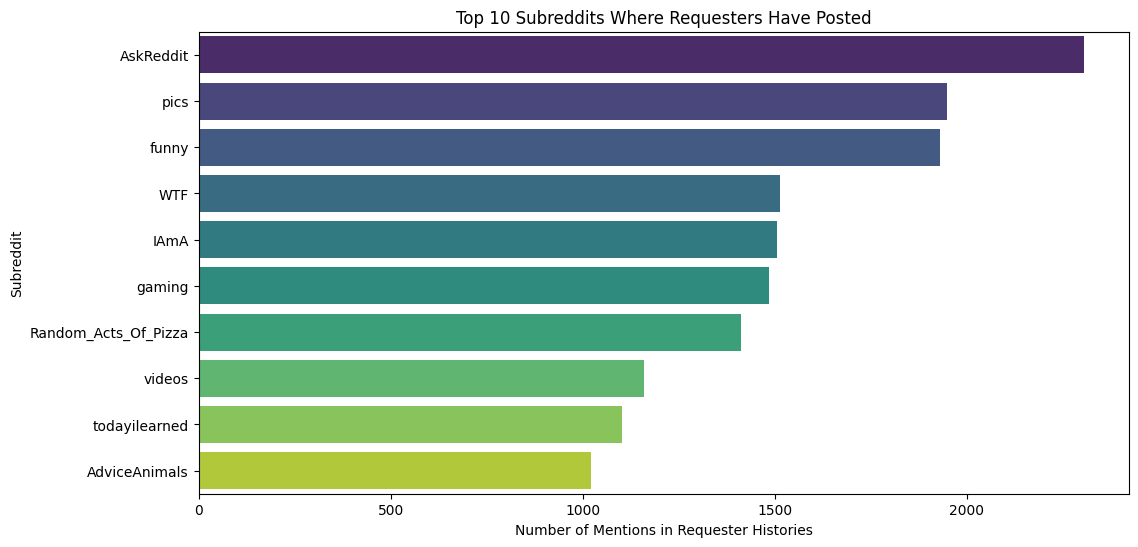

In [6]:
# b. What are the top 10 subreddits the requesters have already posted in the most?

# Flatten the list of lists into a single list of all subreddits mentioned
all_subreddits = [subreddit for sublist in df_clean['requester_subreddits_at_request'] for subreddit in sublist]
print(all_subreddits)
# Use pandas' value_counts() to get the most common ones
top_10_subreddits = pd.Series(all_subreddits).value_counts().head(10)

print("\n--- Top 10 Subreddits by Requester Activity ---")
print(top_10_subreddits)

# Visualize the result
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_subreddits.values, y=top_10_subreddits.index, palette='viridis')
plt.title('Top 10 Subreddits Where Requesters Have Posted')
plt.xlabel('Number of Mentions in Requester Histories')
plt.ylabel('Subreddit')
plt.show()


--- Monthly Active Requesters from Top 10 Subreddits (6-month rolling window) ---
Showing data for the last 12 months in the dataset:
subreddit  AdviceAnimals  AskReddit  IAmA  Random_Acts_Of_Pizza  WTF  pics  \
2012-12              195        422   256                   302  274   351   
2013-01              197        407   248                   387  266   335   
2013-02              213        426   266                   462  282   347   
2013-03              223        444   274                   492  288   364   
2013-04              263        490   309                   496  327   402   
2013-05              288        530   345                   427  365   418   
2013-06              284        513   334                   327  370   401   
2013-07              342        582   383                   240  423   465   
2013-08              387        652   429                   188  473   520   
2013-09              469        759   515                   196  561   609   
2013-10

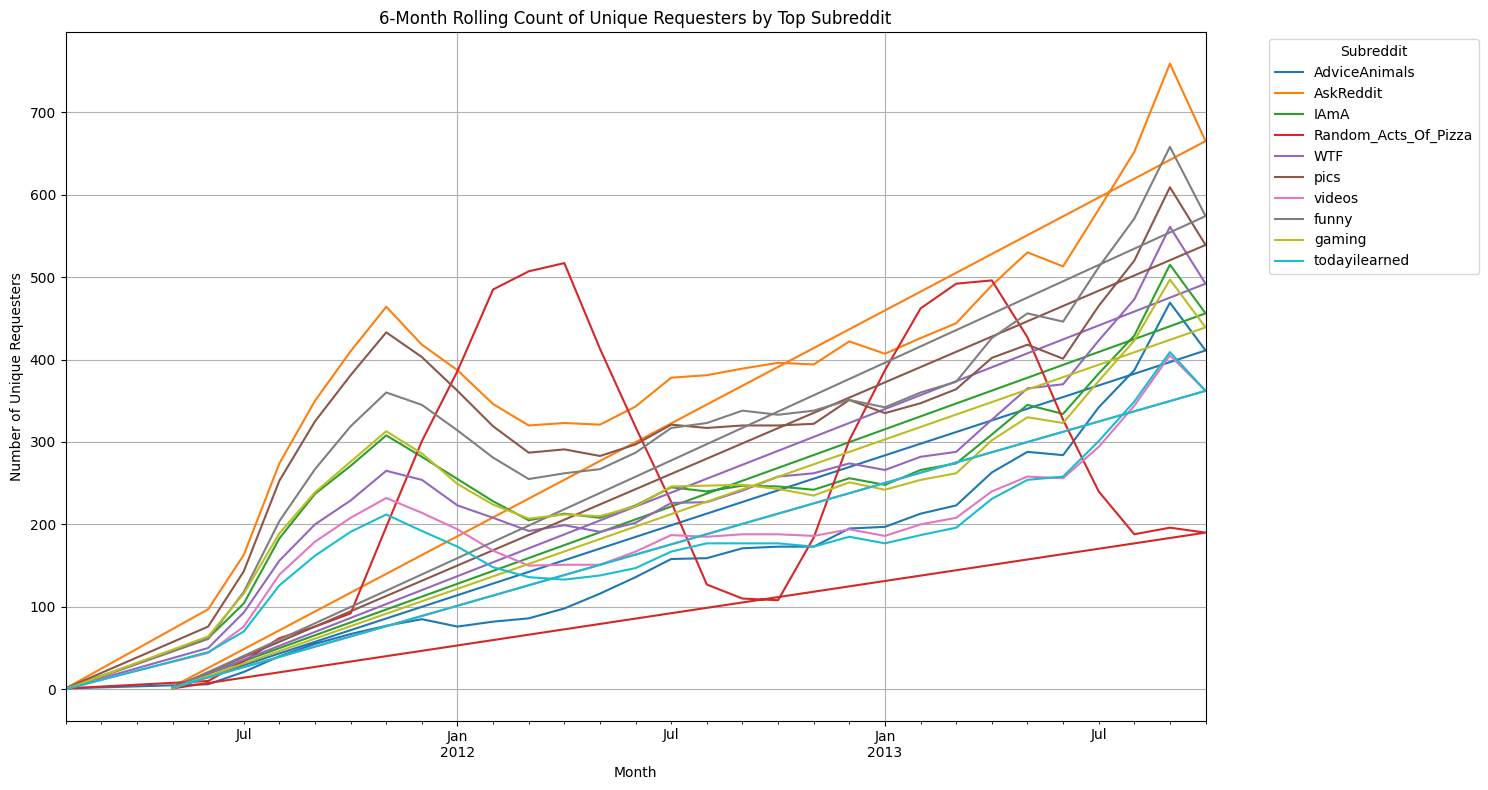

In [7]:
# c. For each of these top 10 subreddits and for each month of data,
#    how many of their active users requested a pizza in the past 6 months?

print("\n--- Monthly Active Requesters from Top 10 Subreddits (6-month rolling window) ---")

# Get the list of top 10 subreddit names
top_10_list = top_10_subreddits.index.tolist()

# Create a DataFrame where each row is a (request_id, subreddit) pair
exploded_df = df_clean.explode('requester_subreddits_at_request')
exploded_df = exploded_df.rename(columns={'requester_subreddits_at_request': 'subreddit'})

# Filter for requests where the user was active in one of the top 10 subreddits
top_subs_df = exploded_df[exploded_df['subreddit'].isin(top_10_list)].copy()

# Set the datetime as the index to use rolling windows easily
top_subs_df.set_index('request_datetime_utc', inplace=True)
top_subs_df.sort_index(inplace=True) # <-- Explicitly sort the index to be safe


# --- THE FINAL, ROBUST SOLUTION ---

# Step 1: For each day and each subreddit, get a list of unique users.
# This is the correct way to perform this initial aggregation.
daily_user_lists = top_subs_df.groupby('subreddit').resample('D')['requester_username'].apply(lambda s: list(set(s)))
# Remove empty days to make the series smaller and more efficient to process
daily_user_lists = daily_user_lists[daily_user_lists.str.len() > 0]


# Step 2: Determine the dates for which we need to perform the calculation.
# We only need the value at the end of each month.
month_end_dates = pd.to_datetime(daily_user_lists.index.get_level_values('request_datetime_utc').to_period('M').unique().to_timestamp(how='end'))


# Step 3: Manually iterate through our target dates and calculate the rolling count.
# This avoids the problematic .rolling() method entirely.
all_monthly_data = []

for end_date in month_end_dates:
    start_date = end_date - pd.Timedelta(days=180)
    
    # Filter the daily data to get the 180-day window for this month-end
    window_df = daily_user_lists.loc[(slice(None), slice(start_date, end_date))]
    
    # For this window, group by subreddit, flatten the lists of users, and count the unique ones
    def flatten_and_count_unique(series_of_lists):
        all_users = set()
        for user_list in series_of_lists:
            all_users.update(user_list)
        return len(all_users)
        
    monthly_counts = window_df.groupby(level='subreddit').apply(flatten_and_count_unique)
    monthly_counts.name = end_date # Name the resulting series with the date for later assembly
    
    all_monthly_data.append(monthly_counts)

# Step 4: Assemble the results into a single, clean DataFrame.
final_df = pd.concat(all_monthly_data, axis=1).T.fillna(0).astype(int)
# Set the index to be the month period for cleaner plotting
final_df.index = final_df.index.to_period('M')


# Display the results for the last 12 months of data for brevity
print("Showing data for the last 12 months in the dataset:")
print(final_df.tail(12))

# Visualize this as a time-series plot
final_df.plot(figsize=(15, 8), grid=True)
plt.title('6-Month Rolling Count of Unique Requesters by Top Subreddit')
plt.ylabel('Number of Unique Requesters')
plt.xlabel('Month')
plt.legend(title='Subreddit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

df_clean

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Assume df_clean and top_10_subreddits_list are defined here ---
# (Using a placeholder setup for a runnable example)
# ... (your df_clean setup code) ...
# ... (your top_10_subreddits_list setup code) ...

# === YOUR ORIGINAL, WORKING CODE - UNCHANGED ===
# This block is treated as a stable, "black box" that produces the correct data.

df_top_10_subreddits['year_month'] = df_top_10_subreddits['request_datetime_utc'].dt.to_period('M')
active_user_month_sub = df_top_10_subreddits.groupby(['year_month', 'requester_subreddits_at_request'])["requester_username"].unique()

def flatten_and_count_unique(window_of_lists):
    unique_users = set()
    for user_list in window_of_lists:
        unique_users.update(user_list)
    return len(unique_users)

def calculate_rolling_unique_count(series_of_lists):
    rolling_counts = []
    for i in range(len(series_of_lists)):
        start_index = max(0, i - 5)
        window = series_of_lists[start_index : i + 1]
        count = flatten_and_count_unique(window)
        rolling_counts.append(count)
    return pd.Series(rolling_counts, index=series_of_lists.index)

final_result = active_user_month_sub.groupby("requester_subreddits_at_request").apply(calculate_rolling_unique_count)


# === THE ELEGANT LINK: A DEDICATED PLOTTING FUNCTION ===

def plot_rolling_data(data_series, title="6-Month Rolling Count of Unique Users"):
    """
    Takes the raw Series from the data processing step and creates the final plot.
    
    This function elegantly handles the necessary transformations:
    1. Renames the messy MultiIndex levels.
    2. Converts the Series to a tidy DataFrame.
    3. Drops the unneeded duplicate column.
    4. Converts the date column to a plottable format.
    """
    print("Preparing data for visualization...")
    
    # Fluent data transformation pipeline
    df_plot = (
        data_series
        .to_frame(name='rolling_count')
        .rename_axis(index=['subreddit', 'date', 'subreddit_dup']) # Explicitly rename index
        .reset_index()                                             # Convert index to columns
        .drop(columns='subreddit_dup')                             # Remove the unneeded column
    )

    # Robustly convert the 'date' column (which is a Period object) to a Timestamp
    df_plot['date'] = df_plot['date'].dt.to_timestamp()

    print("Generating plot...")
    # Create and customize the plot
    plt.figure(figsize=(16, 9))
    sns.set_theme(style="whitegrid")

    sns.lineplot(
        data=df_plot,
        x='date',
        y='rolling_count',
        hue='subreddit',
        marker='o',
        linewidth=2.5
    )
    
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Unique Users (6-Month Rolling Window)', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Subreddit', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()

    plt.show()


# === FINAL STEP: Call the function with your result ===
plot_rolling_data(final_result)

NameError: name 'df_top_10_subreddits' is not defined

# new

In [ ]:
df_clean_exp = df_clean.copy()

In [ ]:
df_clean_exp["year_month"] = df_clean_exp['request_datetime_utc'].dt.to_period('M')

In [ ]:
df_clean_exp.sort_values(by="request_datetime_utc", inplace=True)
df_clean_exp["time_between_requests"] = df_clean_exp['request_datetime_utc'].diff()
df_clean_exp["year_month"] = df_clean_exp['request_datetime_utc'].dt.to_period('M')


# This single chain combines the filtering and aggregation
average_time_per_month = (
    df_clean_exp.groupby("year_month")
    .filter(lambda group: len(group) >= 50) # This keeps only the groups that have 50+ rows
    .groupby("year_month")["time_between_requests"] # Now group again on the filtered data
    .mean()
)

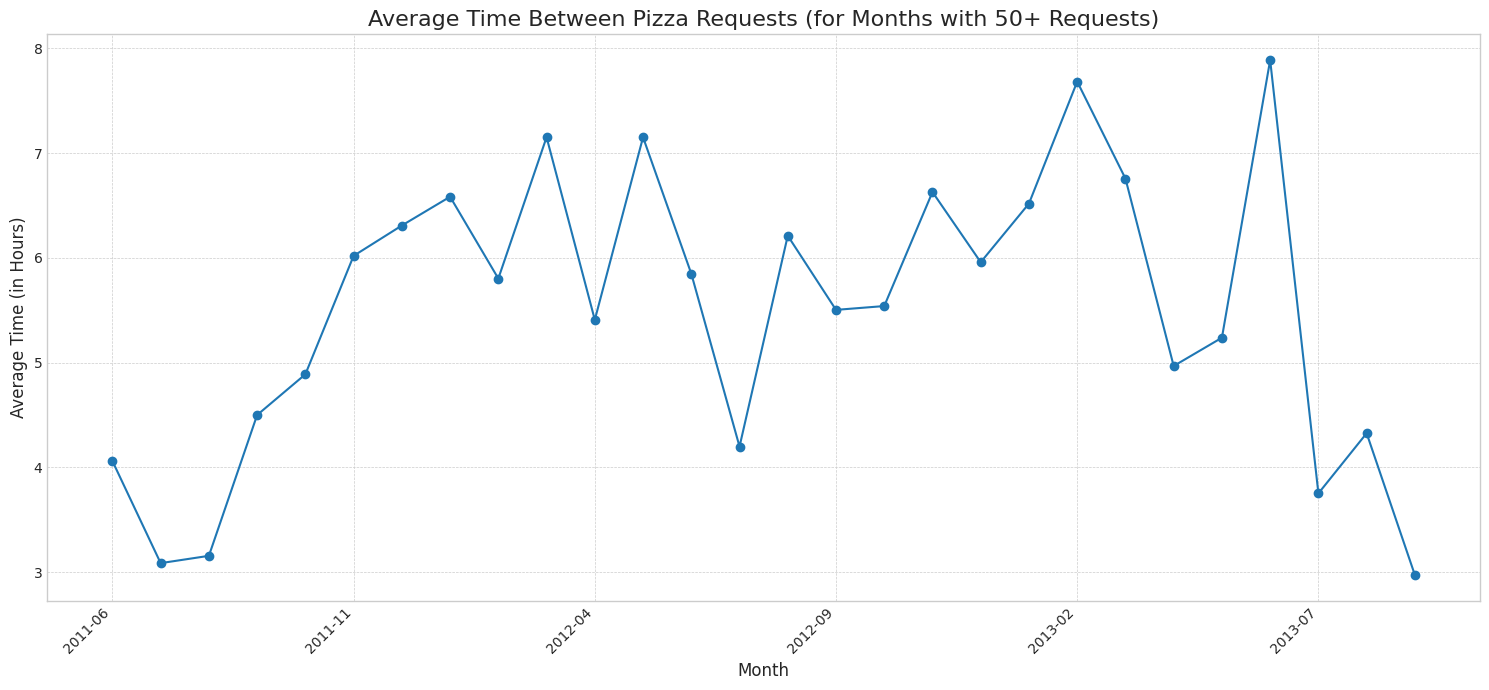

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Assume 'average_time_per_month' is the pandas Series you calculated
# For example:
# year_month
# 2011-12   0 days 02:28:44.204545454
# 2012-01   0 days 02:03:08.355263157
# ...

# 1. Convert Timedelta to a numerical value (total hours) for plotting
# We get total seconds and divide by 3600 to get hours.
average_hours_per_month = average_time_per_month.dt.total_seconds() / 3600

# The index is a PeriodIndex, convert it to string for cleaner labels
average_hours_per_month.index = average_hours_per_month.index.to_series().astype(str)


# 2. Create the plot
plt.style.use('seaborn-v0_8-whitegrid') # Makes the plot look nice
plt.figure(figsize=(15, 7)) # Make the plot larger for better readability

# Plot the data
average_hours_per_month.plot(kind='line', marker='o', linestyle='-')

# 3. Add titles and labels for clarity
plt.title('Average Time Between Pizza Requests (for Months with 50+ Requests)', fontsize=16)
plt.ylabel('Average Time (in Hours)', fontsize=12)
plt.xlabel('Month', fontsize=12)

# 4. Improve readability
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels to prevent overlap
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout() # Adjust layout to make sure everything fits

# 5. Show the plot
plt.show()

# 4. Preprocess the data for the task.

## Feature Selection

In [10]:
y = df_clean['requester_received_pizza']
X = df_clean.drop(columns=['requester_received_pizza'])


Remove Remove Uninformative or Redundant Columns

In [ ]:
columns_to_drop = [
    #request_id, model can't learn a pattern from request_id
    "request_id", 
    # remove unix_timestamp_of_request "incorrect since most RAOP users are from the USA"
    "unix_timestamp_of_request",
    # This is a list of strings, too complex to encode directly.
    # We already have 'requester_number_of_subreddits_at_request' which captures some of this info.
    "requester_subreddits_at_request",  # This is a list of strings,
]
def oed


X = X.drop(columns=['request_id'])
X = X.drop(columns=['unix_timestamp_of_request'])
X = X.drop()'requester_subreddits_at_request'



In [ ]:
X.columns

Index(['request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request_utc', 'request_datetime_utc'],
      dtype='object')

## Feature Engineering

In [ ]:
# Length of Request: A very long, detailed request might be more convincing than a short one.    
X['request_length'] = X['request_text_edit_aware'].str.len()
# Presence of Key Words: Does the request mention things like "job", "student", "party", "family", "kids", "first time"? You can create binary features for these.
# key_words = ['job', 'student', 'party', 'family', 'kids', 'first time']
# for word in key_words:
#     X[f'request_contains_{word}'] = X['request_text_edit_aware'].str.contains(word, case=False, na=False).astype(int)

#Time of Day: Maybe requests made around dinner time are more likely to be fulfilled.      
X['hour_of_request'] = X['request_datetime_utc'].dt.hour
# Day of the Week: A "Friday pizza night" request might have a different success rate.
X['day_of_week'] = X['request_datetime_utc'].dt.dayofweek # Monday=0, Sunday=6
# Is this account only created for RAOP? Or is it a long-time user?
X['raop_post_ratio'] = X['requester_number_of_posts_on_raop_at_request'] / (X['requester_number_of_posts_at_request'] + 1e-6)
# Combine the two text columns into one.
X['full_request_text'] = X['request_title'].fillna('') + ' ' + X['request_text_edit_aware'].fillna('')

# --- 2. Identify columns to drop ---
columns_to_drop = [
    # These have been combined into 'full_request_text'
    'request_title',
    'request_text_edit_aware',

    # These are identifiers or raw data we've already used for feature engineering
    'requester_username',
    'request_datetime_utc',
    'unix_timestamp_of_request_utc',
]

# Drop the columns
X_final = X.drop(columns=columns_to_drop)

print("--- Final columns for the model ---")
print(X_final.columns)
print(X.columns)
# print columns and their types
print("\n--- Feature Columns and Types ---")
print(X.dtypes)


--- Final columns for the model ---
Index(['requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'request_length',
       'hour_of_request', 'day_of_week', 'raop_post_ratio',
       'full_request_text'],
      dtype='object')
Index(['request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_

In [13]:
# Lists of column names based on your refined DataFrame
numeric_features = [
    'requester_account_age_in_days_at_request',
    'requester_days_since_first_post_on_raop_at_request',
    'requester_number_of_comments_at_request',
    'requester_number_of_comments_in_raop_at_request',
    'requester_number_of_posts_at_request',
    'requester_number_of_posts_on_raop_at_request',
    'requester_number_of_subreddits_at_request',
    'requester_upvotes_minus_downvotes_at_request',
    'requester_upvotes_plus_downvotes_at_request',
    'request_length',
    'raop_post_ratio'
]

categorical_features = [
    'hour_of_request',
    'day_of_week'
]

text_feature = 'full_request_text'

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Create the individual transformer pipelines
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
text_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000, stop_words='english'))]) # Increased max_features slightly

# Create the master preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_feature)
    ],
    remainder='drop' # Drop any columns that weren't specified
)

# --- Full Workflow Example ---
# Make sure y is defined (e.g., y = original_df['requester_received_pizza'])
# X_final is the DataFrame you created in Step 1

# Split data BEFORE any fitting
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# Create the full model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000)) # Increased max_iter for convergence
])

# Train the pipeline
model_pipeline.fit(X_train, y_train)

# Evaluate
score = model_pipeline.score(X_test, y_test)
print(f"\nModel accuracy on test set: {score:.4f}")


Model accuracy on test set: 0.7512


In [20]:
print("Fitting the preprocessor on the training data...")
preprocessor.fit(X_train)

# Step 2: Transform both the training and test data
print("Transforming the train and test data...")
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nShape of processed training data: {X_train_processed.shape}")
print(f"Shape of processed test data: {X_test_processed.shape}")


# Step 3: Run FLAML on the pre-processed data
from flaml import AutoML

automl = AutoML()
settings = {
    "time_budget": 120,  # Run for 120 seconds
    "metric": 'roc_auc',
    "task": 'classification',
    "log_file_name": 'flaml_from_pipeline.log',
    "seed": 42
}

print("\nStarting FLAML search on the pre-processed data...")
# Note: We now feed the processed numpy arrays to FLAML
automl.fit(X_train=X_train_processed, y_train=y_train, **settings)
print("FLAML search complete.")

# Step 4: Evaluate the best model found by FLAML
print("\n--- FLAML Results ---")
print(f"Best model found: {automl.model.estimator}")
print(f"Best ROC AUC on validation data: {1 - automl.best_loss:.4f}")

# Evaluate the final model on the holdout processed test set
test_score = automl.score(X_test_processed, y_test)
print(f"\nROC AUC score on holdout test set: {test_score:.4f}")

Fitting the preprocessor on the training data...
Transforming the train and test data...

Shape of processed training data: (3232, 1031)
Shape of processed test data: (808, 1031)

Starting FLAML search on the pre-processed data...
[flaml.automl.logger: 06-23 13:11:44] {1752} INFO - task = classification
[flaml.automl.logger: 06-23 13:11:44] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-23 13:11:44] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 06-23 13:11:44] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 06-23 13:11:44] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-23 13:11:44] {2417} INFO - Estimated sufficient time budget=1266s. Estimated necessary time budget=29s.
[flaml.automl.logger: 06-23 13:11:44] {2466} INFO -  at 0.1s,	estimator lgbm's best error=0.4150,	best estimator lgbm's best error=0.4150
[flaml.automl.lo

In [21]:
import joblib
from sklearn.pipeline import Pipeline

# 1. Retrieve the best model object from the completed FLAML run
best_flaml_model = automl.model.estimator

# 2. Create a final, complete pipeline
# This pipeline chains your preprocessor with the best model found by FLAML
final_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_flaml_model)
])

# 3. Fit the final pipeline on the ENTIRE training dataset
# This retrains the best model on all available training data, making it slightly more robust.
print("Fitting the final pipeline on the entire training set...")
final_model_pipeline.fit(X_train, y_train)
print("Fitting complete.")

# 4. Save the final pipeline object to a file
model_filename = 'pizza_request_model.joblib'
print(f"Saving final model to {model_filename}...")
joblib.dump(final_model_pipeline, model_filename)
print("Model saved successfully.")

# You can now load this single file in your API to make predictions on new raw data.

Fitting the final pipeline on the entire training set...
Fitting complete.
Saving final model to pizza_request_model.joblib...
Model saved successfully.


In [ ]:
# Make sure you have your final feature DataFrame 'X_final' and target Series 'y' ready
# Also, your 'preprocessor' from the previous step must be defined.

# You might need to install lightgbm: pip install lightgbm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

# Create a dictionary of models to test
# The key is the model name, the value is the model instance
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Linear SVM': LinearSVC(random_state=42, dual=False), # dual=False is recommended when n_samples > n_features
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import pandas as pd

# We'll use Stratified K-Folds to ensure each fold has the same proportion of positive/negative classes as the whole dataset
# This is important for imbalanced datasets.
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store the results
results = {}

print("Starting model evaluation...")
for model_name, classifier in models.items():
    # Create the full pipeline by combining the preprocessor with the current classifier
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform cross-validation
    # We'll use 'roc_auc' as our primary scoring metric
    scores = cross_val_score(model_pipeline, X_final, y, cv=cv_strategy, scoring='roc_auc', n_jobs=-1)

    # Store the mean and standard deviation of the scores
    results[model_name] = {
        'mean_roc_auc': np.mean(scores),
        'std_roc_auc': np.std(scores)
    }

    print(f"  {model_name}: Mean ROC AUC = {np.mean(scores):.4f} (± {np.std(scores):.4f})")

print("Model evaluation complete.")

Starting model evaluation...
  Logistic Regression: Mean ROC AUC = 0.6283 (± 0.0181)
  Linear SVM: Mean ROC AUC = 0.5869 (± 0.0200)
  Random Forest: Mean ROC AUC = 0.6252 (± 0.0095)
[LightGBM] [Info] Number of positive: 795, number of negative: 2437
[LightGBM] [Info] Number of positive: 795, number of negative: 2437
[LightGBM] [Info] Number of positive: 795, number of negative: 2437
[LightGBM] [Info] Number of positive: 795, number of negative: 2437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.318695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29060
[LightGBM] [Info] Number of data points in the train set: 3232, number of used features: 923
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.245978 -> initscore=-1.120181
[LightGBM] [Info] Start training from score -1.120181
[LightGBM] [Info] Number of positive: 796, number of negat

/home/gauthier/code/cybel_test/.cybel_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gauthier/code/cybel_test/.cybel_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gauthier/code/cybel_test/.cybel_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gauthier/code/cybel_test/.cybel_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/gauthier/code/cybel_test/.cybel_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning

  LightGBM: Mean ROC AUC = 0.6250 (± 0.0154)
  K-Nearest Neighbors: Mean ROC AUC = 0.5662 (± 0.0300)
Model evaluation complete.


In [ ]:
# Convert the results dictionary to a DataFrame for easy viewing
results_df = pd.DataFrame(results).T # .T transposes the DataFrame to have models as rows

# Sort the DataFrame by the mean score to see the best models at the top
results_df = results_df.sort_values(by='mean_roc_auc', ascending=False)

print("\n--- Model Comparison ---")
print(results_df)


--- Model Comparison ---
                     mean_roc_auc  std_roc_auc
Logistic Regression      0.628334     0.018133
Random Forest            0.625218     0.009548
LightGBM                 0.624957     0.015405
Linear SVM               0.586915     0.020036
K-Nearest Neighbors      0.566205     0.029993


In [17]:
from flaml import AutoML
from sklearn.model_selection import train_test_split

# Assume 'X_final' is your DataFrame with all engineered features
# Assume 'y' is your target Series ('requester_received_pizza')

# --- 1. Prepare the data for FLAML ---
# For this run, we will use all features EXCEPT the raw text column.
X_for_flaml = X_final.drop(columns=['full_request_text'])
y_for_flaml = y.copy() # Make a copy to be safe

# Split the data (FLAML can also do this, but manual split is fine)
X_train, X_test, y_train, y_test = train_test_split(
    X_for_flaml, y_for_flaml, test_size=0.2, random_state=42
)


# --- 2. Initialize and configure AutoML ---
automl = AutoML()

# Settings for the AutoML run
settings = {
    "time_budget": 120,  # Total time in seconds to find the best model
    "metric": 'roc_auc', # Metric to optimize for
    "task": 'classification', # Specify the task type
    "log_file_name": 'flaml_pizza.log', # Log file
    "seed": 42, # For reproducibility
}


# --- 3. Run the AutoML search ---
print("Starting FLAML search...")
automl.fit(X_train=X_train, y_train=y_train, **settings)
print("FLAML search complete.")


# --- 4. Review the results ---
print("\n--- FLAML Results ---")
print(f"Best model found: {automl.model.estimator}")
print(f"Best ROC AUC score on validation data: {1 - automl.best_loss:.4f}") # Loss is 1-score

# You can also see the full configuration of the best model
print("\n--- Best Model Configuration ---")
print(automl.best_config)

# Evaluate the final model on the holdout test set
test_score = automl.score(X_test, y_test)
print(f"\nROC AUC score on holdout test set: {test_score:.4f}")

Starting FLAML search...
[flaml.automl.logger: 06-23 13:01:09] {1752} INFO - task = classification
[flaml.automl.logger: 06-23 13:01:09] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 06-23 13:01:09] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 06-23 13:01:09] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 06-23 13:01:09] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-23 13:01:09] {2417} INFO - Estimated sufficient time budget=1497s. Estimated necessary time budget=35s.
[flaml.automl.logger: 06-23 13:01:09] {2466} INFO -  at 0.2s,	estimator lgbm's best error=0.3864,	best estimator lgbm's best error=0.3864
[flaml.automl.logger: 06-23 13:01:09] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-23 13:01:09] {2466} INFO -  at 0.2s,	estimator lgbm's best error=0.3802,	best estimator lgbm's best error=0.3802
[fl

Fitting the preprocessor on the training data...


ValueError: A given column is not a column of the dataframe

In [ ]:
!pip install "flaml[automl]"

  Using cached FLAML-2.3.5-py3-none-any.whl.metadata (16 kB)
Using cached FLAML-2.3.5-py3-none-any.whl (322 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
!pip install keras
    


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
